In [333]:
import sys
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
from scipy.signal import lfilter, firwin

sys.path.append('../src/')

from bonsai import load_bonsai_config
load_bonsai_config(r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging\Bonsai")

import harp
import harp.processing
import data_io

# sns.set_style("whitegrid")
sns.set_context("talk")
# sns.set_palette("husl")

In [453]:
def fir_filter(data, cutoff_hz, num_taps=61, nyq_rate=1000/2.):

    '''  
    Create a FIR filter and apply it to signal.
    
    nyq_rate (int) = The Nyquist rate of the signal.
    cutoff_hz (float) = The cutoff frequency of the filter: 5KHz
    numtaps (int) = Length of the filter (number of coefficients, i.e. the filter order + 1)
    '''
    
    # Use firwin to create a lowpass FIR filter
    fir_coeff = firwin(num_taps, cutoff_hz/nyq_rate)

    # Use lfilter to filter the signal with the FIR filter
    data["filtered_velocity"] = lfilter(fir_coeff, 1.0, data["velocity"].values)
    
    return data

In [633]:
path = r"Z:\672107\20231013T111657"
session = path[3:9]+'_'+path[10:25]
session_path = Path(path)
# session_path = Path(r"Z:\672103\20231010T104908")


# Harp Devices:
HarpBehavior = harp.HarpDevice("Behavior")
AnalogInput = harp.HarpDevice("AnalogInput")
harp_behavior_data = data_io.HarpSource(device=HarpBehavior, path=session_path / "Behavior", name="behavior", autoload=False)

# Software Events
software_events = data_io.SoftwareEventSource(path=session_path / "SoftwareEvents", name="software_events")
active_site = software_events.streams.ActiveSite.data
active_patch = software_events.streams.ActivePatch.data
# active_patch = software_events.streams.OdorControl.data
stopped = software_events.streams.GiveReward.data


In [634]:
# import json 

# Open and read the JSON file
# with open(str(session_path)+'\config.json', 'r') as json_file:
#     config = json.load(json_file)

In [635]:
try:
    # Open and read the JSON file
    with open(str(session_path)+'\Config\TaskLogic.json', 'r') as json_file:
        config = json.load(json_file)
        
    # Open and read the JSON file
    with open(str(session_path)+'\Config\Rig.json', 'r') as json_file:
        rig = json.load(json_file)
except:
    with open(str(session_path)+'\config.json', 'r') as json_file:
        config = json.load(json_file)


## Load data from encoder efficiently
encoder_data = harp.read_harp_bin(harp_behavior_data.streams.AnalogData.path)

try:
    wheel_size = rig['treadmill']['wheelDiameter']
    PPR = -rig['treadmill']['pulsesPerRevolution']
except:
    wheel_size = 15
    PPR = -8192.0

perimeter = wheel_size*np.pi
resolution = perimeter / PPR
encoder_data['velocity'] = (encoder_data[1] * resolution)*1000

# Reindex the seconds so they are aligned to beginning of the session
start_time = encoder_data.index[0]
# encoder_data.index -= start_time


In [636]:
encoder_data = fir_filter(encoder_data, 5)

In [637]:
# Odor onsets
## mask for digital outputs
digital_outputs = HarpBehavior.module.DigitalOutputs

## Load necessary files
harp_behavior_data.streams.OutputSet.load_from_file()
harp_behavior_data.streams.OutputClear.load_from_file()
odor_0 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort1)
odor_1 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort2)

water_state = harp_behavior_data.streams.OutputSet.data.loc[harp_behavior_data.streams.OutputSet.data["Value"] == digital_outputs.SupplyPort0]

# water_state.index -= start_time
# odor_0.index -= start_time
# odor_1.index -= start_time

In [638]:
# Use json_normalize to create a new DataFrame from the 'data' column
df_normalized = pd.json_normalize(active_patch['data'])
df_normalized.index = active_patch.index

# Concatenate the normalized DataFrame with the original DataFrame
active_patch = pd.concat([active_patch, df_normalized], axis=1)

# Drop the original 'data' column if you want to remove it
active_patch = active_patch.drop('data', axis=1)

active_patch = active_patch[['label', 'stateIndex']]
# active_patch.index = active_patch.index - start_time

In [639]:
active_site = active_site.drop(['timestampSource', 'index'], axis=1)

# Use json_normalize to create a new DataFrame from the 'data' column
df_normalized = pd.json_normalize(active_site['data'])
df_normalized.index = active_site.index

# Concatenate the normalized DataFrame with the original DataFrame
active_site = pd.concat([active_site, df_normalized], axis=1)

# Drop the original 'data' column if you want to remove it
active_site = active_site.drop('data', axis=1)

active_site = active_site[['label', 'startPosition','length']]
# active_site.index = active_site.index - start_time


In [640]:
reward_sites = active_site[active_site['label'] == 'Reward']

In [641]:
# # Create new dataframe that align both odor on and off
# full_odor = pd.DataFrame()
# for odors_onset, odors_offset, value in zip([odor_0.loc[odor_0['Value'] == True].index, odor_1.loc[odor_1['Value'] == True].index], 
#                                             [odor_0.loc[odor_0['Value'] == False].index, odor_1.loc[odor_1['Value'] == False].index],
#                                             [0,1]):

#     #Remove the initial odor valve triggers (usually below 2 seconds)
#     odors_onset = odors_onset[odors_onset-start_time>2]
#     odors_offset = odors_offset[odors_offset-start_time>2]
    
#     assert(odors_onset.shape[0] == odors_offset[:-1].shape[0])

#     full_odor = pd.concat([full_odor, pd.DataFrame({'odor_on': odors_onset, 'odor_off': odors_offset[:-1], 'odor': value})], axis=0)

# # Reorder the dataframe by odor onsets
# full_odor = full_odor.sort_values(by=['odor_on'])

# #Verify that the odor onsets and offsets are paired
# # assert(reward_sites.shape[0] == full_odor.shape[0])

# # Reindex the odor triggers to the reward sites
# full_odor.index = reward_sites.index.values

# # Concatenate the reward sites and odor triggers to the same dataframe
# reward_sites = pd.concat([reward_sites, full_odor], axis=1)


AssertionError: 

In [ ]:
reward_sites['site_count'] = np.arange(reward_sites.shape[0])

In [ ]:
# active_patch['patch_number'] = np.arange(active_patch.shape[0])
# active_patch['patch_number'] += 1
# active_patch.loc[0] = np.repeat(0, len(active_patch.columns))
# active_patch.sort_index(inplace=True)

# reward_sites['patch_time'] = np.nan
# # Create a column for the number of patched the animal has experienced. 
# temp_active_patch = active_patch.copy()
# for index in reward_sites.index:
#     if temp_active_patch.shape[0] == 0:
#         break
#     reward_sites.loc[index, "patch_number"] = temp_active_patch['patch_number'].iloc[0]
#     reward_sites.loc[index, "patch_time"] = float(temp_active_patch.index[0])
#     if index > temp_active_patch.index[0]:
#         temp_active_patch = temp_active_patch.iloc[1:]


In [ ]:
print(reward_sites.loc[reward_sites['odor'] ==0].groupby(['patch_number']).count().label.mean())
print(reward_sites.loc[reward_sites['odor'] ==1].groupby(['patch_number']).count().label.mean())

2.6435185185185186
1.0


In [ ]:
# reward_sites['give_water'] = np.nan
# reward_sites['give_water_time'] = np.nan

# # Create a column for the number of patched the animal has experienced. 
# temp_stopped = stopped.copy()
# for row in reward_sites.itertuples():
#     if row.odor_on < temp_stopped.index[0] < row.odor_off:
#         reward_sites.loc[row.Index, "give_water"] = temp_stopped['data'].iloc[0]
#         reward_sites.loc[row.Index, "give_water_time"] = temp_stopped.index[0]
#         temp_stopped = temp_stopped.iloc[1:]
#     if temp_stopped.shape[0] == 0:
#         break


In [ ]:
# patch_number = -1
# initial_reward = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
# for index, row in reward_sites.iterrows():
#     if row['odor'] == 0:
#         if patch_number != row['patch_number']:
#             patch_number = row['patch_number']
#             current_reward = initial_reward

#         reward_sites.at[index, 'reward_available'] = current_reward
        
#         if row['give_water'] == 1:
#             current_reward -=1
#     else:
#         reward_sites.at[index, 'reward_available'] = 0


In [ ]:
# Remove the last % of the session
maximum_sites = reward_sites.shape[0]*0.5
reward_sites = reward_sites.iloc[:int(round(maximum_sites,0))]
print(maximum_sites)

307.5


C:\Users\tiffany.ona\AppData\Local\Temp\ipykernel_14500\3105897707.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trial_average[i] = trial.values
C:\Users\tiffany.ona\AppData\Local\Temp\ipykernel_14500\3105897707.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trial_average['label'] = odor


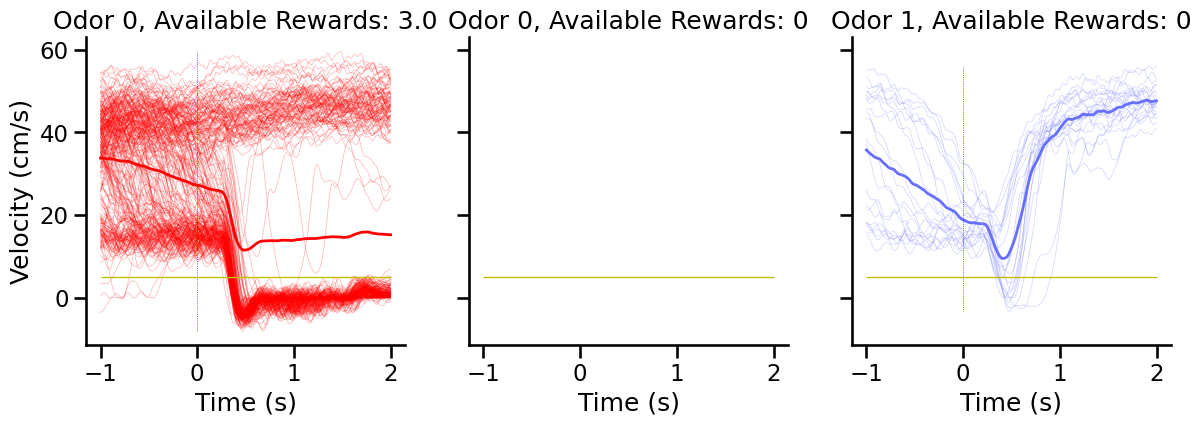

In [ ]:
total_panels = 3
fig,ax = plt.subplots(1,total_panels, figsize=(14,4), sharex=True, sharey=True)
window = (-1, 2)
encoder_patches = pd.DataFrame()

for odor, color, reward_available, grid in zip([0,0,1],['red','red','#666FFF'], 
                                               [reward_sites['reward_available'].max(),0,0], np.arange(total_panels)):
   
    selected_sites = reward_sites.loc[(reward_sites['odor'] == odor)&(reward_sites['reward_available'] == reward_available)]['odor_on']
    # if reward_available == reward_sites['reward_available'].max():
    #     selected_sites = reward_sites.loc[(reward_sites['odor'] == odor)&(reward_sites['reward_available'] >= 4)]['odor_on']

    trial_average = pd.DataFrame()
    for i, start_reward in enumerate(selected_sites):
        trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
        trial.index -=  start_reward
        trial_average[i] = trial.values
        # trial_average = pd.concat([trial_average, trial], ignore_index=True)
        ax[grid].plot(
                        trial.index,
                        trial.values,
                        alpha=0.3, color=color, linewidth=0.5)
    
    trial_average.index = np.arange(window[0], window[1], 1/1000)
    trial_average.mean(axis=1).plot(color=color, linewidth=2, ax=ax[grid])
    trial_average['label'] = odor
    encoder_patches = pd.concat([encoder_patches, trial_average], ignore_index=True)
    ax[grid].vlines(0, trial_average.min().min(), trial_average.max().max(), color='b', linewidth=0.5, linestyles=':')
    ax[grid].set_title(f'Odor {odor}, Available Rewards: {reward_available}')
    # ax[odor].set_title(f' {odor}')
    ax[grid].set_ylabel('Velocity (cm/s)')
    ax[grid].set_xlabel('Time (s)')
    ax[grid].hlines(5, window[0], window[1], color='y', linewidth=1)
    sns.despine()

    

KeyError: 'odor'

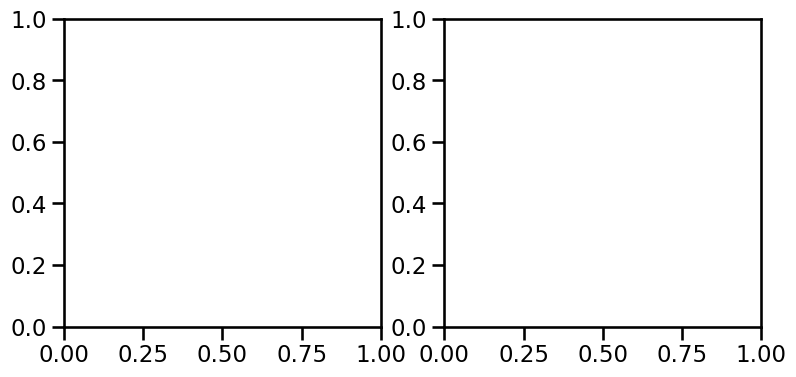

In [ ]:
total_panels = 1
fig,ax = plt.subplots(1,2, figsize=(9,4), sharex=True)
window = (-0.5, 2)
trial_summary = pd.DataFrame()

odor = 1
reward_available = 0
grid=0
selected_sites = reward_sites.loc[(reward_sites['odor'] == odor)]['odor_onset']
for i, start_reward in enumerate(selected_sites):
    trial_average = pd.DataFrame()
    trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
    trial.index -=  start_reward
    ax[grid].plot(
                    trial.index,
                    trial.values,
                    alpha=0.5, color='black', linewidth=0.5)
    
    trial_average['label'] = odor
    trial_average['speed'] = trial.values
    trial_average['times'] = np.arange(window[0], window[1], 1/1000)
    trial_average['reward_available'] = reward_available

    trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    
# ax[odor].set_title(f' {odor}')
ax[grid].set_ylabel('Velocity (cm/s)')
ax[grid].set_xlabel('Time after odor onset (s)')
ax[grid].hlines(5, window[0], window[1], color='black', linewidth=1, linestyles=':')
ax[grid].fill_betweenx(np.arange(-10,60,0.1), 0,2, color='#e41a1c', alpha=.5, linewidth=0)
ax[grid].fill_betweenx(np.arange(-10,60,0.1), -2,0, color='#808080', alpha=.5, linewidth=0)
ax[grid].set_ylim(-10,50)
ax[grid].set_xlim(window)

grid=1
sns.lineplot(x='times', y='speed', data=trial_summary.groupby('times')['speed'].mean().reset_index(),  color='black', ax=ax[grid], linewidth=2)
ax[grid].set_ylabel('Velocity (cm/s)')
ax[grid].set_xlabel('Time after odor onset (s)')
ax[grid].hlines(5, window[0], window[1], color='black', linewidth=1, linestyles=':')
ax[grid].fill_betweenx(np.arange(-10,60,0.1), 0,2, color='#e41a1c', alpha=.5, linewidth=0)
ax[grid].fill_betweenx(np.arange(-10,60,0.1), -2,0, color='#808080', alpha=.5, linewidth=0)

ax[grid].set_ylim(-10,50)
ax[grid].set_xlim(window)

sns.despine()
plt.savefig(r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Figures\patch_1' + session+'.png', dpi=300, bbox_inches='tight')
plt.savefig(r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Figures\patch_1' + session+'.svg', dpi=300, bbox_inches='tight')

# sns.despine(trim=True)

    

In [ ]:
# total_panels = 2
# fig,ax = plt.subplots(1,total_panels, figsize=(8,4), sharex=True, sharey=True)
# fig.tight_layout()
# window = (-1, 2)
# encoder_patches = pd.DataFrame()

# for odor, color, reward_available, grid in zip([0,1],['red','#666FFF'], 
#                                                [reward_sites['reward_available'].max(),0], np.arange(total_panels)):
   
#     selected_sites = reward_sites.loc[(reward_sites['previous_patch'] == 1)&(reward_sites['odor'] == odor)&(reward_sites['reward_available'] == reward_available)]['odor_on']

#     trial_average = pd.DataFrame()
#     for i, start_reward in enumerate(selected_sites):
#         trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
#         trial.index -=  start_reward
        
#         trial_average['label'] = odor
#         trial_average['speed'] = trial.values
#         trial_average['times'] = np.arange(window[0], window[1], 1/1000)
#         trial_average['reward_available'] = reward_available

#         # trial_average = pd.concat([trial_average, trial], ignore_index=True)
#         ax[grid].plot(
#                         trial.index,
#                         trial.values,
#                         alpha=0.3, color=color, linewidth=0.5)
    
#         encoder_patches = pd.concat([encoder_patches, trial_average], ignore_index=True)
        
#     ax[grid].vlines(0, trial_average.min().min(), trial_average.max().max(), color='black', linewidth=2, linestyles=':')
#     ax[grid].set_title(f'Odor {odor}, Available Rewards: {reward_available}')
#     # ax[odor].set_title(f' {odor}')
#     ax[grid].set_ylabel('Velocity (cm/s)')
#     ax[grid].set_xlabel('Time (s)')
#     ax[grid].hlines(5, window[0], window[1], color='black', linewidth=2)

    

In [ ]:
# reward_sites['previous_patch'] = reward_sites['odor'].shift(1)

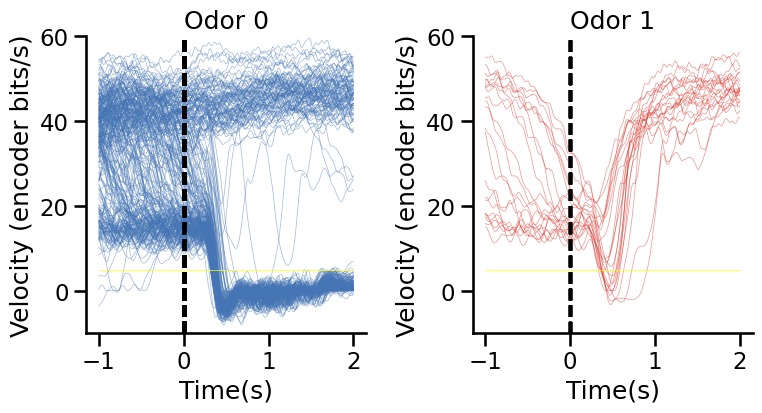

In [ ]:
# pallete = sns.color_palette("Spectral", n_colors=len(reward_sites['reward_available'].unique()))
pallete = ['#d73027','#fdae61','#abd9e9','#4575b4']

trial_summary = pd.DataFrame()

window = (-1, 2)
fig, axs = plt.subplots(1,2, figsize=(8,4), sharex=True)
fig.tight_layout()

ylim = (-10, 60)

for i, (odor_label, odor_group) in enumerate(reward_sites.groupby("odor")):
    for trial in odor_group.iterrows():
        trial_average = pd.DataFrame()
        odor_onset = trial[1]["odor_on"]
        enconder_slice = encoder_data.loc[odor_onset + window[0]: odor_onset + window[1], 'filtered_velocity']
        color = pallete[int(trial[1]["reward_available"])]
        axs[i].plot(
            enconder_slice.index.values - odor_onset,
            enconder_slice.values,
            color=color, alpha=0.5, lw = 0.5)
        axs[i].set_ylim(ylim)
        axs[i].vlines(0, ymin=-10, ymax= 60, color="k", linestyle="--")
                
        trial_average['label'] = odor_label
        trial_average['speed'] = enconder_slice.values
        trial_average['times'] = enconder_slice.index.values - odor_onset
        trial_average['reward_available'] = int(trial[1]["reward_available"])
    
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

    axs[i].set_title(f"Odor {int(odor_label)}")
    axs[i].set_xlabel("Time(s)")
    axs[i].set_ylabel("Velocity (encoder bits/s)")
    axs[i].hlines(5, window[0], window[1], color='yellow', linewidth=0.5)
    
    plt.savefig(r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Figures\reward_available'+session+'.png', dpi=300, bbox_inches='tight')
    plt.savefig(r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Figures\reward_available'+session+'.svg', dpi=300, bbox_inches='tight')

    sns.despine()


C:\Users\tiffany.ona\AppData\Local\Temp\ipykernel_14500\1361805440.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trial_average[i] = trial.values
C:\Users\tiffany.ona\AppData\Local\Temp\ipykernel_14500\1361805440.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trial_average['label'] = odor


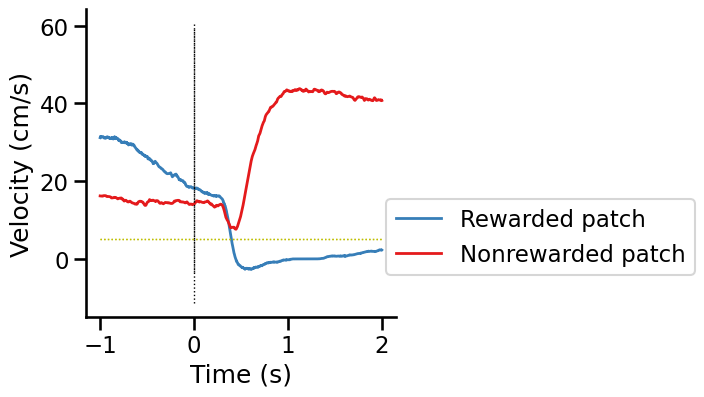

In [ ]:
total_panels = 1
fig,ax = plt.subplots(1,total_panels, figsize=(4,4))
window = (-1, 2)
encoder_patches = pd.DataFrame()

for odor, color, reward_available, grid,label in zip([0,1],['#377eb8', '#e41a1c'], 
                                               [reward_sites['reward_available'].max(),0], [0,0], 
                                               ['Rewarded patch','Nonrewarded patch']):
   
    selected_sites = reward_sites.loc[(reward_sites['odor'] == odor)&(reward_sites['reward_available'] == reward_available)]['odor_on']
    # if reward_available == reward_sites['reward_available'].max():
    #     selected_sites = reward_sites.loc[(reward_sites['odor'] == odor)&(reward_sites['reward_available'] >= 0)]['odor_on']

    trial_average = pd.DataFrame()
    for i, start_reward in enumerate(selected_sites):
        trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
        trial.index -=  start_reward
        trial_average[i] = trial.values
        # trial_average = pd.concat([trial_average, trial], ignore_index=True)
    
    trial_average.index = np.arange(window[0], window[1], 1/1000)
    trial_average.median(axis=1).plot(color=color, linewidth=2, ax=ax, label=label)
    trial_average['label'] = odor
    encoder_patches = pd.concat([encoder_patches, trial_average], ignore_index=True)
    ax.vlines(0, trial_average.min().min(), trial_average.max().max(), color='black', linewidth=1, linestyle=':')
    ax.legend(loc='lower right', bbox_to_anchor=(2, 0.1))
    # ax[odor].set_title(f' {odor}')
    ax.set_ylabel('Velocity (cm/s)')
    ax.set_xlabel('Time (s)')
    ax.hlines(5, window[0], window[1], color='y', linewidth=1, linestyles=':')
    sns.despine()
    
    plt.savefig(r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Figures\patches_'+session+'.png', dpi=300, bbox_inches='tight')
    plt.savefig(r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\Figures\patches_'+session+'.svg', dpi=300, bbox_inches='tight')
    

In [ ]:
# session_path = Path(r"Z:\672107\20231010T120003")
session_path = Path(r"Z:\672103\20231010T104908")

# Harp Devices:
HarpBehavior = harp.HarpDevice("Behavior")
AnalogInput = harp.HarpDevice("AnalogInput")
harp_behavior_data = data_io.HarpSource(device=HarpBehavior, path=session_path / "Behavior", name="behavior", autoload=False)

# Software Events
software_events = data_io.SoftwareEventSource(path=session_path / "SoftwareEvents", name="software_events")
active_site = software_events.streams.ActiveSite.data
active_patch = software_events.streams.ActivePatch.data
# active_patch = software_events.streams.OdorControl.data
stopped = software_events.streams.GiveReward.data


# Open and read the JSON file
with open(str(session_path)+'\Config\TaskLogic.json', 'r') as json_file:
    config = json.load(json_file)
    
# Open and read the JSON file
with open(str(session_path)+'\Config\Rig.json', 'r') as json_file:
    rig = json.load(json_file)


## Load data from encoder efficiently
encoder_data = harp.read_harp_bin(harp_behavior_data.streams.AnalogData.path)

wheel_size = rig['treadmill']['wheelDiameter']
PPR = -rig['treadmill']['pulsesPerRevolution']

perimeter = wheel_size*np.pi
resolution = perimeter / PPR
encoder_data['velocity'] = (encoder_data[1] * resolution)*1000

# Reindex the seconds so they are aligned to beginning of the session
start_time = encoder_data.index[0]
# encoder_data.index -= start_time

encoder_data = fir_filter(encoder_data, 5)

# Odor onsets
## mask for digital outputs
digital_outputs = HarpBehavior.module.DigitalOutputs

## Load necessary files
harp_behavior_data.streams.OutputSet.load_from_file()
harp_behavior_data.streams.OutputClear.load_from_file()
odor_0 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort1)
odor_1 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort2)

# Use json_normalize to create a new DataFrame from the 'data' column
df_normalized = pd.json_normalize(active_site['data'])
df_normalized.index = active_site.index

# Concatenate the normalized DataFrame with the original DataFrame
active_site = pd.concat([active_site, df_normalized], axis=1)

active_site = active_site[['label', 'startPosition','length']]

reward_sites = active_site[active_site['label'] == 'Reward']


# Create new dataframe that align both odor on and off
full_odor = pd.DataFrame()
for odors_onset, odors_offset, value in zip([odor_0.loc[odor_0['Value'] == True].index, odor_1.loc[odor_1['Value'] == True].index], 
                                            [odor_0.loc[odor_0['Value'] == False].index, odor_1.loc[odor_1['Value'] == False].index],
                                            [0,1]):

    #Remove the initial odor valve triggers (usually below 2 seconds)
    odors_onset = odors_onset[odors_onset-start_time>2]
    odors_offset = odors_offset[odors_offset-start_time>2]
    
    assert(odors_onset.shape[0] == odors_offset.shape[0])

    full_odor = pd.concat([full_odor, pd.DataFrame({'odor_on': odors_onset, 'odor_off': odors_offset, 'odor': value})], axis=0)

# Reorder the dataframe by odor onsets
full_odor = full_odor.sort_values(by=['odor_on'])

#Verify that the odor onsets and offsets are paired
assert(reward_sites.shape[0] == full_odor.shape[0])

# Reindex the odor triggers to the reward sites
full_odor.index = reward_sites.index.values

# Concatenate the reward sites and odor triggers to the same dataframe
reward_sites = pd.concat([reward_sites, full_odor], axis=1)

reward_sites['give_reward'] = np.nan
# Create a column for the number of patched the animal has experienced. 
temp_stopped = stopped.copy()
for row in reward_sites.itertuples():
    if row.odor_on < temp_stopped.index[0] < row.odor_off:
        reward_sites.loc[row.Index, "give_water"] = temp_stopped['data'].iloc[0]
        reward_sites.loc[row.Index, "give_water_time"] = temp_stopped.index[0]
        temp_stopped = temp_stopped.iloc[1:]
    if temp_stopped.shape[0] == 0:
        break


# Use json_normalize to create a new DataFrame from the 'data' column
df_normalized = pd.json_normalize(active_patch['data'])
df_normalized.index = active_patch.index

# Concatenate the normalized DataFrame with the original DataFrame
active_patch = pd.concat([active_patch, df_normalized], axis=1)

active_patch = active_patch[['label', 'stateIndex']]

active_patch['patch_number'] = np.arange(active_patch.shape[0])
active_patch['patch_number'] += 1
active_patch.loc[0] = np.repeat(0, len(active_patch.columns))
active_patch.sort_index(inplace=True)

reward_sites['patch_time'] = np.nan
# Create a column for the number of patched the animal has experienced. 
temp_active_patch = active_patch.copy()
for index in reward_sites.index:
    if temp_active_patch.shape[0] == 0:
        break
    
    reward_sites.loc[index, "patch_number"] = temp_active_patch['patch_number'].iloc[0]
    reward_sites.loc[index, "patch_time"] = float(temp_active_patch.index[0])
    if index > temp_active_patch.index[0]:
        temp_active_patch = temp_active_patch.iloc[1:]

patch_number = 0
initial_reward = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
current_reward = initial_reward
for index, row in reward_sites.iterrows():
    if row['odor'] == 0:
        if patch_number != row['patch_number']:
            patch_number = row['patch_number']
            current_reward = initial_reward

        reward_sites.at[index, 'reward_available'] = current_reward
        
        if row['give_water'] == 1:
            current_reward -=1
    else:
        reward_sites.at[index, 'reward_available'] = 0


### Old way of plotting the data

In [ ]:
path = r"Z:\vr-foraging\672107\20230920T125148\Behavior\Register__"

In [ ]:

df  = harp.read_harp_bin(path+str(44)+".bin")
perimeter = 15*np.pi
resolution = perimeter / -8192
df['velocity'] = (df[1] * resolution)*1000

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\vr-foraging\\672107\\20230920T125148\\Behavior\\Register__44.bin'

In [ ]:
odor_df  = harp.read_harp_bin(path+str(34)+".bin")


In [ ]:
water_on = harp.read_harp_bin(path+str(34)+".bin")
water_on = water_on.loc[water_on['Value'] & 0x08 > 0] * 0 + 1
water_off = harp.read_harp_bin(path+str(35)+".bin")
water_off = water_off.loc[water_off['Value'] & 0x08 > 0] * 0
water = pd.concat([water_on, water_off], join='outer', sort=True)


In [ ]:
odor1_on = harp.read_harp_bin(path+str(34)+".bin")
odor1_on = odor1_on.loc[odor1_on['Value'] & 16 > 0] * 0 + 1
odor1_off = harp.read_harp_bin(path+str(35)+".bin")
odor1_off = odor1_off.loc[odor1_off['Value'] & 16 > 0] * 0
odor1 = pd.concat([odor1_on, odor1_off], join='outer').sort_index()
odor1 = odor1.loc[odor1.Value.diff() != 0]

In [ ]:
# // calculate running window for velocity in df
def running_average(numbers, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0")
    
    running_averages = []
    window_sum = 0
    
    for i, num in enumerate(numbers):
        window_sum += num
        
        if i >= window_size - 1:
            average = window_sum / window_size
            running_averages.append(average)
            window_sum -= numbers[i - window_size + 1]
    
    return running_averages

In [ ]:
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
from scipy.signal import lfilter, firwin
nyq_rate = 1000 / 2.

# The cutoff frequency of the filter: 6KHz
cutoff_hz = 5.0

# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 61

# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)

# Use lfilter to filter the signal with the FIR filter
df["filtered_velocity"] = lfilter(fir_coeff, 1.0, df["velocity"].values)



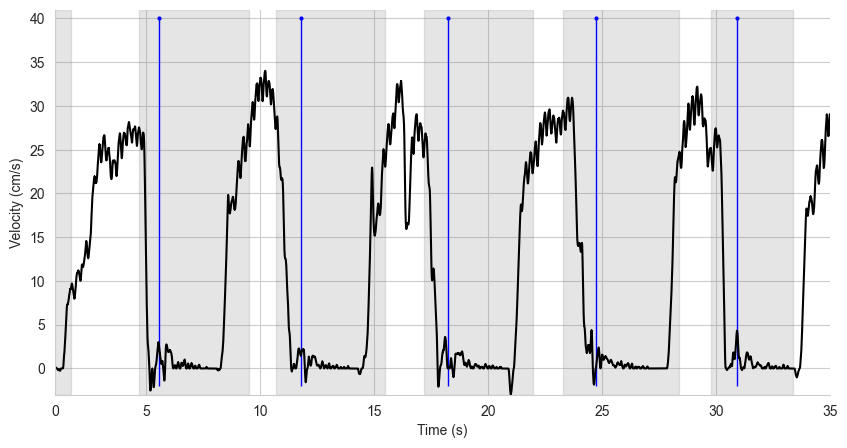

In [ ]:

plt.figure(figsize=(10, 5))

# plt.plot(odor1.loc[odor1.Value == 1].index,  np.repeat(40, len(odor1.loc[odor1.Value == 1])),  marker='x', linestyle='none', markersize=5, color='crimson')
# plt.vlines(odor1.loc[odor1.Value == 1].index, ymin=-2, ymax=40, color='crimson', linewidth=1)

# plt.plot(odor1.loc[odor1.Value == 0].index,  np.repeat(40, len(odor1.loc[odor1.Value == 0])),  marker='x', linestyle='none', markersize=5, color='pink')
# plt.vlines(odor1.loc[odor1.Value == 0].index, ymin=-2, ymax=40, color='pink', linewidth=1)

plt.plot(water.index,  np.repeat(40, len(water)),  marker='o', linestyle='none', markersize=2, color='blue')
plt.vlines(water.index, ymin=-2, ymax=40, color='blue', linewidth=1)

plt.plot(df.index.values, df["filtered_velocity"], color='black')
plt.xlim(98963, 98995)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')

# Shade the background
plt.axvspan(98963.7, 98950.7, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98966.7, 98971.5, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98972.7, 98977.5, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98979.2, 98984.0, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98985.3, 98990.4, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98991.8, 98995.4, alpha=0.2, color='grey', label='Shaded Area')


sns.despine()
# Define custom tick positions and labels for the x-axis
custom_xticks = [98963, 98967, 98972, 98977, 98982, 98987, 98992, 98997]
custom_xtick_labels = [0, 5, 10, 15, 20,25,30,35]
# Set custom ticks and labels for the x-axis
plt.xticks(custom_xticks, custom_xtick_labels)
plt.ylim(-3,41)
plt.savefig('672107.png', dpi=300, bbox_inches='tight')

In [ ]:
import json

# //load json file
with open(r'D:\672107\20230920T125148\config.json') as f:
  data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\672107\\20230920T125148\\config.json'

In [ ]:
import json

# //load json file
with open(r'Z:\vr-foraging\672107\20230925T114601\SoftwareEvents\ChoiceFeedback.json') as f:
  data = json.load(f)

In [ ]:
df['time_intervals']= df.index.diff()
df.fillna(0.001, inplace=True)
df

In [ ]:
def calculate_distance(speeds, time_intervals):
    if len(speeds) != len(time_intervals):
        raise ValueError("Length of speeds and time_intervals must be the same")

    distance = 0.0

    for i in range(len(speeds)):
        delta_t = time_intervals[i]
        v = speeds[i]
        distance += v * delta_t

    return distance

# Example usage:
speeds = df["velocity"].values  # Instantaneous speeds in m/s
time_intervals = df['time_intervals'].values  # Time intervals in seconds

total_distance = calculate_distance(speeds, time_intervals)
print(f"Total distance traveled: {total_distance} meters")


In [ ]:

def calculate_instantaneous_positions(speeds, time_intervals):
    if len(speeds) != len(time_intervals):
        raise ValueError("Length of speeds and time_intervals must be the same")

    positions = [0.0]  # Initialize with an initial position of 0
    for i in range(len(speeds)):
        delta_t = time_intervals[i]
        v = speeds[i]
        position = positions[-1] + v * delta_t
        positions.append(position)
    
    return positions[1:]

# Example usage:
speeds = df["velocity"].values  # Instantaneous speeds in m/s
time_intervals = df['time_intervals'].values  # Time intervals in seconds

instantaneous_positions = calculate_instantaneous_positions(speeds, time_intervals)
print("Instantaneous positions (meters):", instantaneous_positions)
df['instantaneous_positions'] = instantaneous_positions

In [ ]:
pd.concat([odor1,df]).sort_index()

In [ ]:
plt.plot(df['instantaneous_positions'], df['filtered_velocity'], color='black')

plt.plot(odor1.loc[odor1.Value == 1].index,  np.repeat(40, len(odor1.loc[odor1.Value == 1])),  marker='x', linestyle='none', markersize=5, color='crimson')
plt.vlines(odor1.loc[odor1.Value == 1].index, ymin=-10, ymax=40, color='crimson', linewidth=1)

plt.plot(odor1.loc[odor1.Value == 0].index,  np.repeat(40, len(odor1.loc[odor1.Value == 0])),  marker='x', linestyle='none', markersize=5, color='pink')
plt.vlines(odor1.loc[odor1.Value == 0].index, ymin=-10, ymax=40, color='pink', linewidth=1)

plt.plot(water.index,  np.repeat(40, len(water)),  marker='o', linestyle='none', markersize=2, color='blue')
plt.vlines(water.index, ymin=-10, ymax=40, color='blue', linewidth=1)

plt.xlim(1500, 1700)
sns.despine()
plt.xlabel("Distance(cm)")
plt.ylabel("Spped(cm/s)")